In [60]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import importlib
import torch

import RDM_task as rdm
import FullRankRNN as rnn
#from files import REINFORCE as rnf

In [61]:
importlib.reload(rdm)

task = rdm.PerceptualDecisionMaking()

In [62]:
importlib.reload(rnn)

input_size = 3
hidden_size = 128
output_size = 3

actor_network = rnn.FullRankRNN(input_size, hidden_size, output_size, 
                                noise_std=5e-2, alpha=0.2, rho=0.8, 
                                train_wi=True, train_wo=True)

input_size += hidden_size
hidden_size = 128
output_size = 1

critic_network = rnn.FullRankRNN(input_size, hidden_size, output_size, 
                                 noise_std=5e-2, alpha=0.2, rho=0.8, 
                                 train_wi=True, train_wo=True)

In [63]:
obs = []
actions = []
rewards = []
probs = []
values = []
n_tr = 5
time_step = 0
store_trial_begin = [time_step]
trial_index = 0

In [65]:
task.reset()
action = 0

while trial_index < n_tr:           
    ob, reward, done, info = task.step(action=action)
    action_probs, trajs = actor_network(ob, return_dynamics=True)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    value = critic_network(action, trajs)
    new_trial = info["new_trial"]
    obs.append(ob)
    rewards.append(reward)
    actions.append(action)
    probs.append(action_probs[action])
    values.append(value)
    if new_trial:
        trial_index += 1
        store_trial_begin.append(time_step)
        
    time_step += 1
log_probs = np.log(probs)



RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [56]:
cum_rho = []

for i in range(n_tr):
    start = int(store_trial_begin[i])
    stop = int(store_trial_begin[i+1])
    trial_rewards = np.flip(np.array(rewards[start:stop]))
    cumulative_rewards = np.zeros(len(trial_rewards))
    cumulative_reward = 0
    
    for j in range(len(trial_rewards)):
        cumulative_reward +=  trial_rewards[j]
        cumulative_rewards[j] = cumulative_reward
        
    cum_rho.append(cumulative_rewards)
            
print(trial_rewards)
print(cumulative_rewards)


[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1  0.
 -0.1 -0.1  0.   0.   0.   0.   0.  -0.1  0.  -0.1  0.   0.  -0.1  0.
 -0.1  0.   0.   0.   0.   0.  -0.1  0.   0.   0.   0.  -0.1  0.   0.
 -0.1 -0.1  0.   0.  -0.1  0.   0.   0.   0.  -0.1  0.   0.   0. ]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  9.00000000e-01  9.00000000e-01  8.00000000e-01  7.00000000e-01
  7.00000000e-01  7.00000000e-01  7.00000000e-01  7.00000000e-01
  7.00000000e-01  6.00000000e-01  6.00000000e-01  5.00000000e-01
  5.00000000e-01  5.00000000e-01  4.00000000e-01  4.00000000e-01
  3.00000000e-01  3.00000000e-01  3.00000000e-01  3.00000000e-01
  3.00000000e-01  3.00000000e-01  2.00000000e-01  2.00000000e-01
  2.00000000e-01  2.00000000e-01  2.00000000e-01  1.00000000e-01
  1.00000000e-01  1.00000000e-01  1.38777878e-16 -1.00000000e-01
 -1.0000

In [58]:
cum_rho = []
tau_r = np.inf  # Song et al. set this to 10s only for reaction time tasks
gradient_per_trial = 0
for i in range(n_tr):
    start = int(store_trial_begin[i])
    stop = int(store_trial_begin[i+1])
    trial_rewards = np.array(rewards[start:stop])
    trial_logprobs = log_probs([start:stop])
    trial_values = values([start:stop])
    cumulative_rewards = [] # np.zeros(len(trial_rewards))
    cumulative_reward = 0
    
    for j in range(len(trial_rewards)):
        disc_rew = [r*np.exp(-(i_r+1)/tau_r) for i_r, r in enumerate(trial_rewards[j+1:])]
        cumulative_rewards.append(np.sum(disc_rew))
        gradient_per_trial += trial_logprobs[j].backward() * (np.sum(disc_rew) - trial_values[j])
    cum_rho.append(cumulative_rewards)
            
print(trial_rewards)
print(cumulative_rewards)

[ 0.   0.   0.  -0.1  0.   0.   0.   0.  -0.1  0.   0.  -0.1 -0.1  0.
  0.  -0.1  0.   0.   0.   0.  -0.1  0.   0.   0.   0.   0.  -0.1  0.
 -0.1  0.   0.  -0.1  0.  -0.1  0.   0.   0.   0.   0.  -0.1 -0.1  0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1. ]
[-0.30000000000000004, -0.30000000000000027, -0.30000000000000004, -0.20000000000000018, -0.20000000000000018, -0.20000000000000018, -0.20000000000000007, -0.20000000000000018, -0.10000000000000009, -0.10000000000000009, -0.10000000000000009, 0.0, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.19999999999999996, 0.19999999999999996, 0.19999999999999996, 0.19999999999999996, 0.19999999999999996, 0.29999999999999993, 0.29999999999999993, 0.29999999999999993, 0.29999999999999993, 0.29999999999999993, 0.29999999999999993, 0.4, 0.3999999999999999, 0.5, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]


In [41]:
log_probs = np.log(probs)
gradient_per_trial = 0
value = 0
gradient_per_trial += log_probs[].backward() * (cumulative_reward[n_and_t] - value)


SyntaxError: invalid syntax (<ipython-input-41-e17b9c8f8851>, line 3)

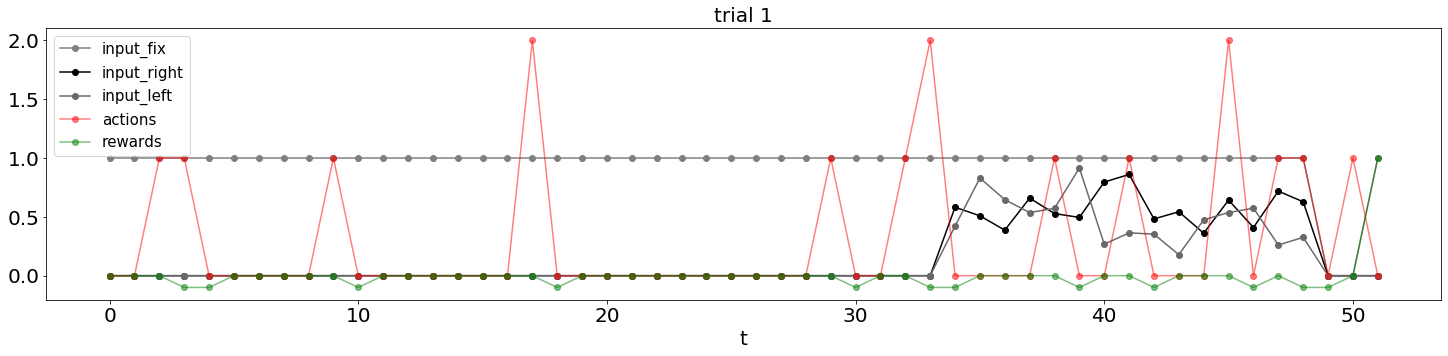

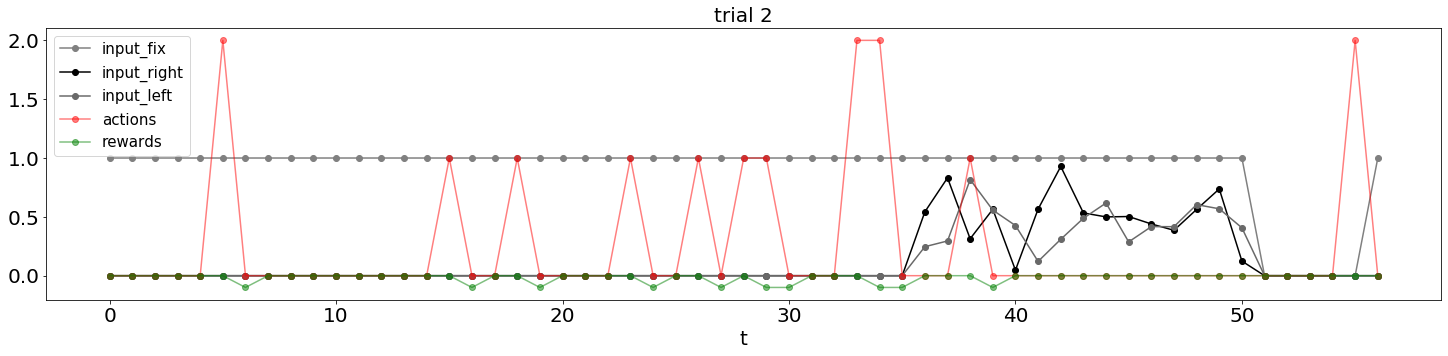

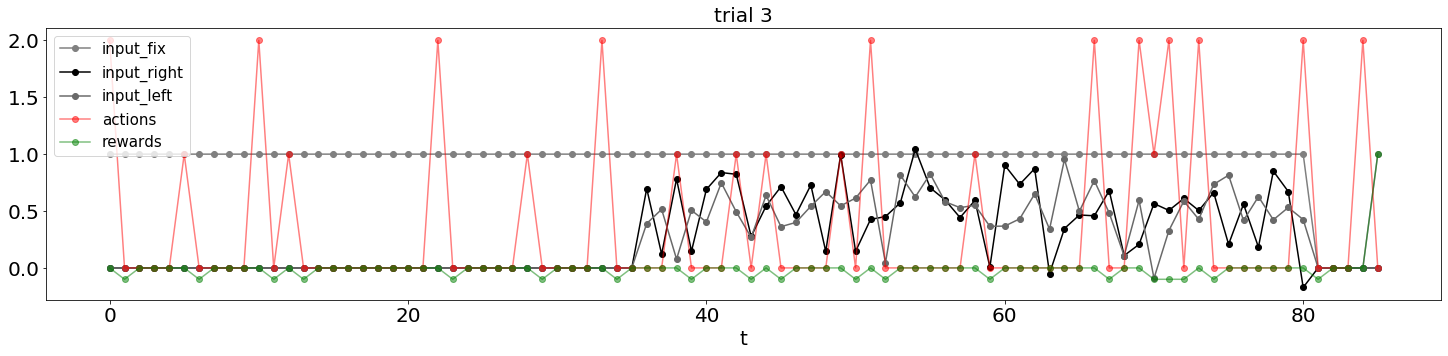

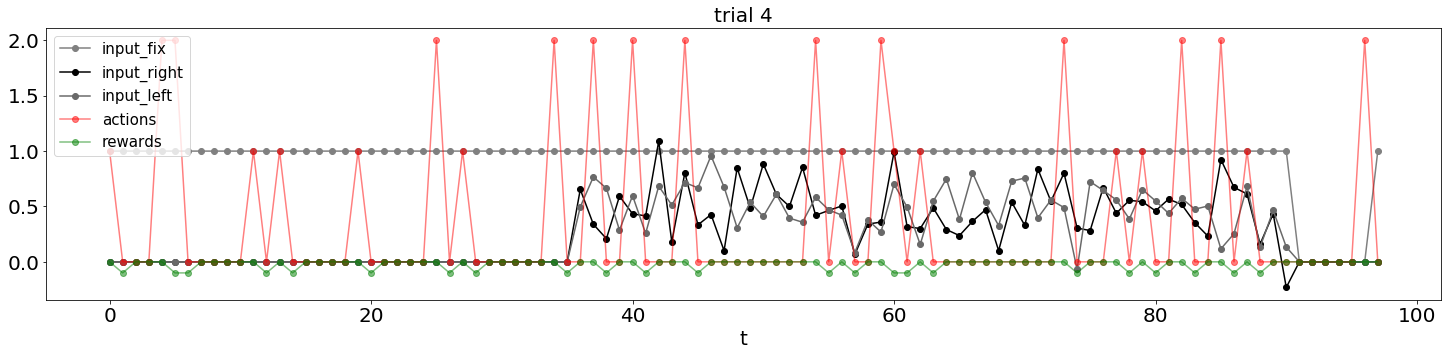

In [51]:
obs = np.asarray(obs)
obs = obs.T
#print(obs)

for i in range(n_tr-1):

    plt.figure(figsize=(25,5))
    
    start = int(store_trial_begin[i])
    stop = int(store_trial_begin[i+1])
    plt.plot(obs[0][start:stop], "-o", label="input_fix", color="gray")
    plt.plot(obs[1][start:stop], "-o", label="input_right", color="black")
    plt.plot(obs[2][start:stop], "-o", label="input_left", color="dimgray")
    plt.plot(actions[start:stop], "-o", label="actions", color="red", alpha=0.5)
    plt.plot(rewards[start:stop], "-o", label="rewards", color="green", alpha=0.5)
    
    plt.xlabel("t", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("trial %i" %(i+1), size=20)
    plt.legend(fontsize=15, loc="upper left");